Code pour l'épreuve intégrée : "Implémentation d'un filtre de Kalman afin de réduire le bruit d'un capteur".
Réalisé par Alessandro Farina
Année 2025-2026

Ce code est composé de plusieurs sections:
Section 1 : Librairies
Section 2 : Variables
Section 3 : Signaux
    3.1. Signal sinusoïdal
    3.2. Bruit blanc Gaussien
    3.3. Signal sinusoïdal bruité
    3.4. Passe-bas #1
    3.5. Passe-bas #2
Section 4 : Filtre de Kalman
Section 5 : Graphiques
    5.1. Mise en graphique du signal d'entrée pure
    5.2. Mise en graphique du bruit blanc Gaussien
    5.3. Mise en graphique du signal d'entrée bruité
    5.4. Graphique Bode Nyquist du/des filtres passe-bas
    5.5. Mise en graphique des signaux de sortie du/des passe-bas
    5.6. Mise en graphique de la sortie du filtre de Kalman
    5.7. Graphiques comparatifs Signal d'entrée bruité, Signal de sortie du passe-bas, Kalman
    5.8. Mise en graphique du ripple pré/post Kalman
    5.9. Mise en graphique de la moyenne glissante et du filtre de Kalman

Sources:
math : https://docs.python.org/3/library/math.html
scipy : https://pypi.org/project/scipy/
fft : https://docs.scipy.org/doc/scipy/tutorial/fft.html#fourier-transforms-scipy-fft
filterpy.kalman : https://filterpy.reaDThedocs.io/en/latest/kalman/KalmanFilter.html
numpy : https://pypi.org/project/numpy/
matplotlib : https://pypi.org/project/matplotlib/
csv : https://docs.python.org/fr/3/library/csv.html

Ce programme à pour but de générer un signal sinusoïdal bruité, filtré par un capteur (qui est représenté par un filtre passe-bas de premier ordre). La sortie de ce capteur est introduit dans un Filtre de Kalman. Divers autres tests sont également effectué sur ce code (tels que calculs de SNR, Moyennes Glissantes, répétitivité, ...)

Section 1 : Librairies

/ math est utilisée pour les fonctions mathématiques (pi, sin)
/ scipy.signal est utilisée pour les filtres (butter = butterworth, lfilter = filtre passe-bas)
/ pykalman ou filterpy.kalman sont utilisées pour le filtre de Kalman
/ numpy est utilisée pour les matrices
/ matplotlib est utilisée pour les graphiques
/ csv est utilisée pour la manipulation des fichiers csv
/ CLASS.py est utilisée pour des objets créés (tel que pour le traitement des filtres)

In [109]:
#Importation des classes dans le fichier CLASS.py
#Elles contiennent:
# La classe Signal_Original pour générer le signal d'entrée
# La classe SignalFilter pour appliquer les filtres
# La classe Graphiques pour afficher les graphiques
# La classe Monte_Carlo pour réaliser la méthode de Monte Carlo
# La fonction Moyenne_Glissante pour appliquer une moyenne glissante
# La fonction Calc_Retard pour le calcul du retard entre deux signaux
# La fonction Calc_SNR pour le calcul sur SNR
# La fonction CSV_Export pour exporter les données en .csv
# La fonction Calc_Stab_Gain_KF pour calculer la durée de stabilité du gain de Kalman
from CLASS import * 
from math import sin, pi #import les fonction sinus et pi de la bibliothèque math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

Classes et fonctions: (présentes dans le fichier CLASS.py)

La fonction Signal_Original permet de générer le signal d'entrée (pur) en fonction des variables reçues:
/ Signal_Type = s'il s'agit d'un signal sinusoïdal ou carré (attention qu'un signal carré est non-linéaire => utiliser EKF)
/ Amplitude = amplitude du signal
/ Fréquence = fréquence du signal
/ Durée = durée du signal
/ Fs = Fréquence d'échantillonage
/ Abscisse_Graph = abscisse du graphique

La fonction SignalFilter permet de générer le fonctionnement des 2 filtres utilisés (passe-bas et Kalman) appelé respectivement via Filtre_passe_bas(self) et Filtre_kalman(self, Sortie_Filtre). On retrouve les paramètres suivants:
/ signal = le signal à filtrer, utilisé comme signal d'entrée du filtre (quelque soit son type)
/ filter_type = indique s'il faut utiliser un filtre passe-bas ou un Kalman (peut-être amélioré sur un passe-haut? Nécessaire?)
/ gain = gain du filtre passe-bas
/ fc = fréquence de coupure du filtre passe-bas
/ ordre = ordre du filtre passe-bas
/ fs = fréquence d'échantillonage
/ Q = matrice de covariance du bruit de mesure (pour Kalman)
/ P = matrice de covariance du bruit de process (pour Kalman)
/ Noise_STD = écart-type du bruit blanc Gaussien
/ Entrée_Pure = signal d'entrée pur (pour Kalman)

Fonction plot_graph pour réaliser un affichage d'un graphique avec comme paramètres:
/ x est l'abscisse
/ y est l'ordonnée
/ xlabel est le nom de l'axe des abscisses
/ ylabel est le titre de l'axe des ordonnées
/ legend est la légende du graphique

Fonction zoom_graph pour réaliser un zoom sur un graphique avec comme paramètres:
/ x est l'abscisse
/ y est l'ordonnée
/ xlim représente les bornes de la limite du zoom pour les abscisses
/ ylim représente les bornes de la limite du zoom pour les ordonnées
/ title est le titre du graphique
/ xlabel est le nom de l'axe des abscisses
/ ylabel est le titre de l'axe des ordonnées

Fonction FFT_Signal pour réaliser une FFT d'un signal. Elle a besoin des paramètres suivants:
/ signal est le signal à traiter dans la FFT
/ fs est la fréquence d'échantillonage
/ xlimit est la limite pour le zoom sur le graphique (si nécessaire, peut valoir None)

Fonction Bode_Diagram pour plot le diagramme de bode d'un capteur. Elle a besoin des paramètres suivants:
/ fc = fréquence de coupure du filtre passe-bas
/ gain = gain du filtre passe-bas
/ titre = titre du graphique pour représenter le diagramme

Fonction Moyenne_Glissante pour le calcul d'une moyenne glissante (pour comparaison avec le KF)

Fonction Calc_retard pour calculer le retard temporel entre 2 signaux + conversion en degré

Fonction Calc_SNR qui calcule du SNR d'un signal

Section 2 : Variables

/ TIMEINOPERATION représente la durée de mesure en seconde
/ FREQ_SAMPLE représente la fréquence d'échantillonage
/ ABSCISSE_GRAPH représente l'axe des abscisses utilisée dans tous les graphiques

In [110]:
TIMEINOPERATION = 2 #donne la durée de l'opération en secondes
FREQ_SAMPLE = 5000    #fréquence d'échantillonnage en Hz
ABSCISSE_GRAPH = np.linspace(0, TIMEINOPERATION, (FREQ_SAMPLE*TIMEINOPERATION), endpoint=False)    #abscisse du graphique temporel en secondes
DT = 1/FREQ_SAMPLE  #pas de temps entre deux échantillons en secondes

/ ABSCISSE_GRAPH_TEMPOREL est la variable qui stocke le texte des abscisses des graphiques temporels
/ ORDONNEE_GRAPH_TEMPOREL est la variable qui stocke le texte des ordonnées des graphiques temporels
/ ABSCISSE_GRAPH_FFT est la variable qui stocke le texte des abscisses des graphiques FFT
/ ORDONNEE_GRAPH_FFT est la variable qui stocke le texte des ordonnées des graphiques FFT
/ ORDONNEE_GRAPH_BODE_GAIN est la variable qui stocke le texte des ordonnées des graphiques Bode Nyquist (Gain)
/ ABSCISSE_GRAPH_BODE_PHASE est la variable qui stocke le texte des abcsisses des graphiques Bode Nyquist (Phase)
/ ORDONNEE_GRAPH_BODE_PHASE est la variable qui stocke le texte des ordonnées des graphiques Bode Nyquist (Phase)
/ ABSCISSE_GRAPH_DISTRIB_GAUSSIENNE est la variable qui stocke le texte des abscisses des graphiques de distribution Gaussienne
/ ORDONNEE_GRAPH_DISTRIB_GAUSSIENNE est la variable qui stocke le texte des ordonnées des graphiques de distribution Gaussienne

In [111]:
ABSCISSE_GRAPH_TEMPOREL = "Temps [s]"   #titre de l'abscisse du graphique temporel
ORDONNEE_GRAPH_TEMPOREL = "Amplitude [V]"   #titre de l'ordonnée du graphique temporel
ABSCISSE_GRAPH_FFT = "Fréquence (Hz)"   #titre de l'abscisse du graphique FFT
ORDONNEE_GRAPH_FFT = "Amplitude (V)"    #titre de l'ordonnée du graphique FFT
ORDONNEE_GRAPH_BODE_GAIN = "Gain (dB)"  #titre de l'ordonnée du graphique de Bode (gain)
ABSCISSE_GRAPH_BODE_PHASE = "Fréquence (Hz)"    #titre de l'abscisse du graphique de Bode (phase)
ORDONNEE_GRAPH_BODE_PHASE = "Phase (degrés)"   #titre de l'ordonnée du graphique de Bode (phase)
ABSCISSE_GRAPH_DISTRIB_GAUSSIENNE = "Amplitude [V]"  #titre de l'abscisse du graphique de la distribution gaussienne
ORDONNEE_GRAPH_DISTRIB_GAUSSIENNE = "Densité de probabilité"    #titre de l'ordonnée du graphique de la distribution gaussienne

Variables utilisées pour la génération d'un signal sinusoïdal:
    / Sinus_Frequence représente la fréquence du signal en THz
    / Sinus_Amplitude représente l'amplitude du signal en cd

In [112]:
SIGNAL_IN_FREQUENCE = 100  #fréquence du signal d'entrée en Hz
SIGNAL_IN_AMPLITUDE = 0.5  #amplitude du signal d'entrée en V

Variables pour la génération du bruit blanc Gaussien (généré suivant une loi Normale):
    / W_NOISE_MEAN représente la moyenne
    / W_NOISE_STD représente l'écart-type (soit valeur RMS)

In [113]:
W_NOISE_MEAN = 0.   #moyenne du bruit blanc gaussien en V
W_NOISE_STD = 0.2   #écart-type du bruit blanc gaussien en V

Variables pour les filtres passe-bas
    / filtre_liste permet d'allouer un espace pour l'ajout de plusieurs filtre (généralisation)
    / filtre_id permet de connaître l'id (la position) du filtre dans la matrice
    / Filtre_fc représente la fréquence de coupure du filtre
    / Filtre_Ordre représente l'ordre du filtre
    / Filtre_type représente le type de filtre (bas, haut)

In [114]:
filtre_liste = []   #liste des filtres à appliquer

FILTRE_ID_1 = 1 #identifiant du filtre 1
FILTRE_FC_1 = 210   #fréquence de coupure du filtre 1 en Hz
FILTRE_ORDRE_1 = 1  #ordre du filtre 1
FILTRE_TYPE_1 = 'passe-bas' #type du filtre 1
FILTRE_GAIN_1 = 1.  #gain du filtre 1
FILTRE_R_1 = 0.04  #variance du bruit de mesure du filtre 1

filtre_liste.append([FILTRE_ID_1, 
                     FILTRE_FC_1, 
                     FILTRE_ORDRE_1, 
                     FILTRE_TYPE_1, 
                     FILTRE_GAIN_1, 
                     FILTRE_R_1])   #ajout du filtre 1 à la liste des filtres

FILTRE_ID_2 = 2   #identifiant du filtre 2
FILTRE_FC_2 = 250  #fréquence de coupure du filtre 2 en Hz
FILTRE_ORDRE_2 = 1    #ordre du filtre 2
FILTRE_TYPE_2 = 'passe-bas'   #type du filtre 2
FILTRE_GAIN_2 = 1.    #gain du filtre 2
FILTRE_R_2 = 0.04  #variance du bruit de mesure du filtre 2

filtre_liste.append([FILTRE_ID_2, 
                     FILTRE_FC_2, 
                     FILTRE_ORDRE_2, 
                     FILTRE_TYPE_2, 
                     FILTRE_GAIN_2, 
                     FILTRE_R_2])  #ajout du filtre 2 à la liste des filtres

Variables pour les coefficients de la représentation d'état pour le filtre de Kalman suivant la librairie pykalman
    / Kalman_A est la matrice de transition de l'état
    / Kalman_B est la matrice de contrôle
    / Kalman_C est la matrice d'observation
    / Kalman_D est la matrice de contrôle
    / Kalman_Q est le bruit de processus
    / Kalman_R est le bruit de mesure
    / Kalman_P est la matrice de covariance de l'état initial
    / Kalman_x est le vecteur d'état initial    

In [115]:
tau_pb_1 = 2 * np.pi * FILTRE_FC_1 #constante de temps du filtre passe-bas 1
tau_pb_2 = 2 * np.pi * FILTRE_FC_2 #constante de temps du filtre passe-bas 2

KALMAN_A = np.diag([exp(-1/tau_pb_1),exp(-1/tau_pb_2)]) #matrice d'état 2x2
KALMAN_B = [[1 - exp(-1/tau_pb_1)],[1 - exp(-1/tau_pb_2)]]  #matrice de contrôle 2x1
KALMAN_C = np.diag([1,1]) #matrice de mesure 2x2

KALMAN_Q = np.diag([W_NOISE_MEAN**2, W_NOISE_MEAN**2])  #valeur de la variance du bruit de processus
KALMAN_R = np.diag([FILTRE_R_1, FILTRE_R_2]) #0.04 #valeur de la variance du bruit de mesure initiale
KALMAN_P0 = np.eye(2) #1.  #valeur de la variance de l'estimation initiale
KALMAN_X0 = np.zeros((2,1)) #0.  #valeur de l'état initial

Taille fenêtre de la moyenne glissante

In [116]:
TAILLE_FENETRE_MOYENNE_GLISSANTE = 20   #taille de la fenêtre pour la moyenne glissante

Section 3 : Signal d'entrée

Section 3.1. : Signal sinusoïdal
    / Génération d'un signal sinusoïdal ou carré en fonction du paramètre de l'objet

In [117]:
generation_signal_entrée = Signal_Original("sinus", 
                                           SIGNAL_IN_AMPLITUDE, 
                                           SIGNAL_IN_FREQUENCE, 
                                           TIMEINOPERATION, 
                                           FREQ_SAMPLE, 
                                           ABSCISSE_GRAPH)  #création du signal d'entrée
signal_entree = generation_signal_entrée.GenerationSignal() #génération du signal d'entrée

### TESTS SUPPLEMENTAIRES POUR MODIFIER LE SIGNAL D'ENTREE ###
#Modification de frequence ou amplitude du signal d'entrée ici si besoin
# for i in range(len(signal_entree)):
#     if (ABSCISSE_GRAPH[i] >= 1.85):
#         signal_entree[i] = 2*SIGNAL_IN_AMPLITUDE*sin(2*pi*(SIGNAL_IN_FREQUENCE*0.8)*ABSCISSE_GRAPH[i])

#Modification de la fréquence du signal d'entrée après un certain temps
# for i in range(len(signal_entree)):
#     if ABSCISSE_GRAPH[i] >= 1.85:
#         signal_entree[i] = SIGNAL_IN_AMPLITUDE*sin(2*pi*(SIGNAL_IN_FREQUENCE*0.7)*ABSCISSE_GRAPH[i])

#Superposition de plusieurs signaux de différentes fréquences
# for i in range(len(signal_entree)):
#      if (ABSCISSE_GRAPH[i] >= 1.85) and (ABSCISSE_GRAPH[i] < 1.95):
#          signal_entree[i] = SIGNAL_IN_AMPLITUDE*(sin(2*pi*(SIGNAL_IN_FREQUENCE)*ABSCISSE_GRAPH[i]) + sin(2*pi*(SIGNAL_IN_FREQUENCE*0.7)*ABSCISSE_GRAPH[i]) + sin(2*pi*(SIGNAL_IN_FREQUENCE*1.5)*ABSCISSE_GRAPH[i]) + sin(2*pi*(SIGNAL_IN_FREQUENCE*0.92)*ABSCISSE_GRAPH[i]))
### FIN DES TESTS SUPPLEMENTAIRES ###

Section 3.4. : Passe-bas

Signal filtré par le(s) capteur(s) (et génération du bruit blanc gaussien sur base d'une loi Normale N(moyenne, écart-type))

In [118]:
sortie_filtre=0  #initialisation de la somme des sorties des filtres
for i in filtre_liste:  #parcours de la liste des filtres
    ### ligne à commenter / pour générer le signal bruité ici, hors perte de données ###
    gaussian_noise = np.random.normal(W_NOISE_MEAN, W_NOISE_STD, FREQ_SAMPLE * TIMEINOPERATION) #génération du bruit blanc gaussien
    signal_bruité = signal_entree + gaussian_noise #génération du signal d'entrée bruité

    filtre = SignalFilter(signal_bruité, 
                          i[3], 
                          i[4], 
                          i[1], 
                          i[2], 
                          FREQ_SAMPLE, 
                          W_NOISE_STD, 
                          signal_entree)   #création du filtre
    
    ### TESTS SUPPLEMENTAIRES POUR MODIFIER LE SIGNAL BRUITE ###
    #suppression d'une partie du signal d'entrée pour tester le filtre de Kalman
    # for i in range(len(signal_bruité)):
    #     if (ABSCISSE_GRAPH[i] >= 1.85) and (ABSCISSE_GRAPH[i] < 1.86):
    #         signal_bruité[i] = 0.

    ##suppression totale du signal d'entrée après stabilisation du gain de Kalman
    # for i in range(len(signal_bruité)):
    #     if ABSCISSE_GRAPH[i] >= 0.01:
    #         signal_bruité[i] = 0.
    ### FIN DES TESTS SUPPLEMENTAIRES ###
    
    if i[0] == 1:
        sortie_filtre = filtre.Sortie_Filtre_passe_bas()    #application du filtre
    else:
        filtre_temp = filtre.Sortie_Filtre_passe_bas()    #application du filtre
        sortie_filtre = np.hstack((sortie_filtre.reshape(-1,1), filtre_temp.reshape(-1,1)))   #création du filtre

Section 4 : Filtre de Kalman

Filtre de Kalman par filtrepy et utilisation de la fonction précédemment créée

In [119]:
filtered, kalman_gains = filtre.Filtre_kalman(sortie_filtre,
                                              KALMAN_A,
                                              KALMAN_B,
                                              KALMAN_C,
                                              KALMAN_P0,
                                              KALMAN_Q,
                                              KALMAN_R,
                                              KALMAN_X0)    #application du filtre de Kalman

Calcul du ripple pré et post filtre de Kalman

In [120]:
ripple = np.abs(signal_entree - filtered)   #calcule de l'erreur entre le signal d'entrée et le signal filtré

Calcul d'une moyenne glissante sur le signal bruité

In [121]:
signal_moving_average = Moyenne_Glissante(signal_bruité, 
                                          TAILLE_FENETRE_MOYENNE_GLISSANTE)  #application de la moyenne glissante

Calcul du SNR des différentes étapes (signal d'entrée bruitée, signal filtré par passe-bas, signal filtré par Kalman, signal filtré par moyenne glissante)

In [122]:
Calc_SNR(signal_entree, 
         signal_bruité, 
         "V", 
         "Signal Bruité")    #Calcul du SNR entre le signal d'entrée et le signal bruité
Calc_SNR(signal_entree, 
         sortie_filtre, 
         "V", 
         "Signal Filtré par passe-bas") #Calcul du SNR entre le signal d'entrée et le signal filtré par le capteur 
Calc_SNR(signal_entree, 
         filtered, 
         "V", 
         "Signal Filtré Kalman")  #Calcul du SNR entre le signal d'entrée et le signal filtré par le filtre de Kalman
Calc_SNR(signal_entree, 
         signal_moving_average, 
         "V", 
         "Signal Moyenne Glissante") #Calcul du SNR entre le signal d'entrée et le signal filtré par la moyenne glissante

RMS Signal d'entrée : 0.35355339059327373 V
RMS Signal bruité : 0.4027473736580353 Signal Bruité
SNR Signal Bruité : -1.1315542106748129 dB
RMS Signal d'entrée : 0.35355339059327373 V
RMS Signal bruité : 0.33059909903541307 Signal Filtré par passe-bas
SNR Signal Filtré par passe-bas : 0.5830668165445039 dB
RMS Signal d'entrée : 0.35355339059327373 V
RMS Signal bruité : 0.32643177650976996 Signal Filtré Kalman
SNR Signal Filtré Kalman : 0.6932515591348343 dB
RMS Signal d'entrée : 0.35355339059327373 V
RMS Signal bruité : 0.2693142229877356 Signal Moyenne Glissante
SNR Signal Moyenne Glissante : 2.363914331662584 dB


Export en csv pour tests sur Excel

In [123]:
# CSV_Export("Output_20251116_double_capt.csv", 
#            ABSCISSE_GRAPH, 
#            signal_entree, 
#            signal_bruité, 
#            sortie_filtre, 
#            filtered)    #export des données dans un fichier CSV

Section 5: Graphiques

5.1. : Mise en graphique du signal d'entrée pur

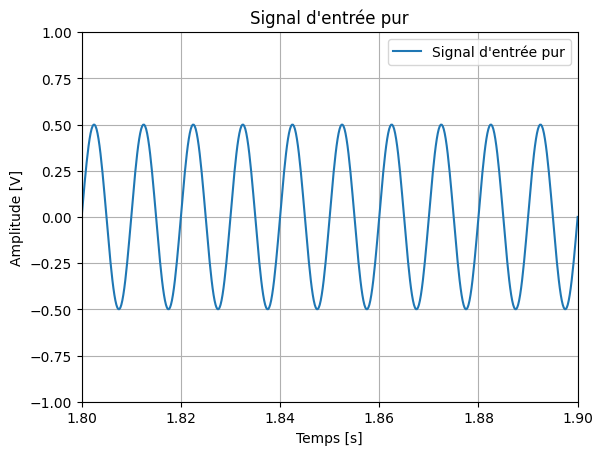

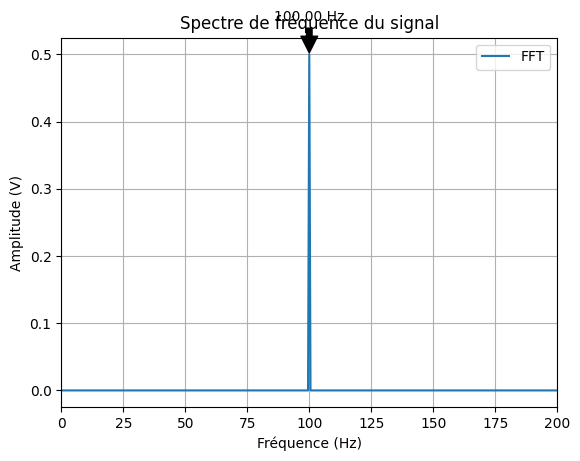

In [124]:
signal_graph = Graphiques() #création de l'objet pour les graphiques
signal_graph.plot_graph(ABSCISSE_GRAPH, 
                        signal_entree, 
                        'Signal d\'entrée pur', 
                        ABSCISSE_GRAPH_TEMPOREL, 
                        ORDONNEE_GRAPH_TEMPOREL, 
                        'Signal d\'entrée pur', 
                        (1.8, 1.9), 
                        (-1., 1.)) #affichage du graphique du signal d'entrée
signal_graph.FFT_Signal(signal_entree, 
                        FREQ_SAMPLE, 
                        (0, 200), 
                        ABSCISSE_GRAPH_FFT, 
                        ORDONNEE_GRAPH_FFT)   #affichage du graphique FFT du signal d'entrée

5.2. : Mise en graphique du bruit blanc Gaussien

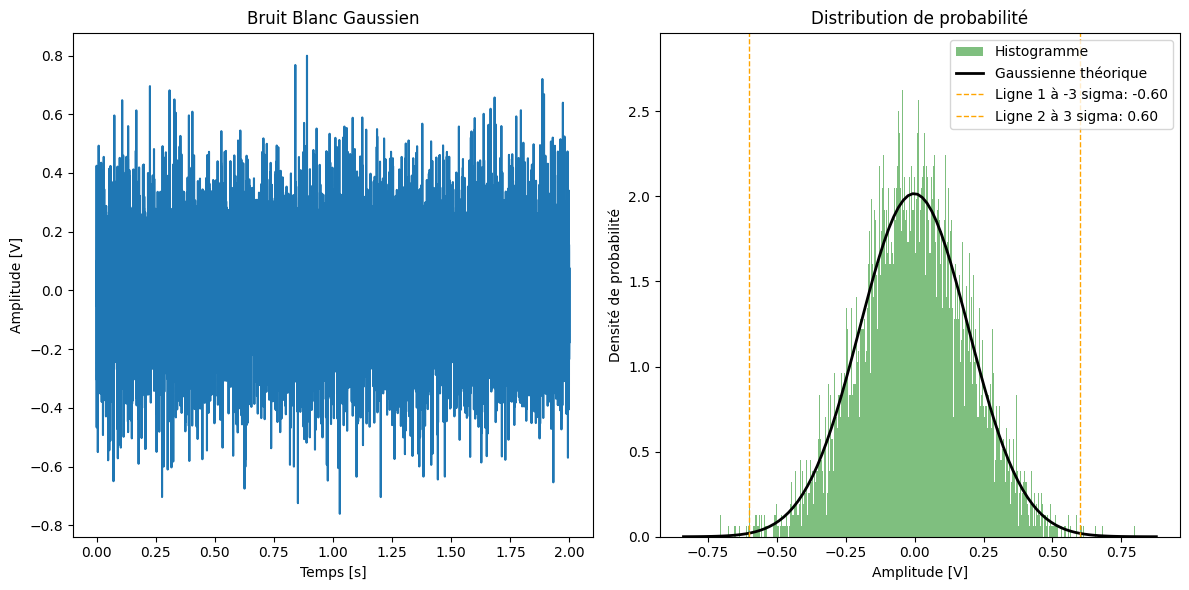

In [125]:
signal_bruit = Graphiques() #création de l'objet pour les graphiques du bruit
signal_bruit.plot_hist_gaussienne(gaussian_noise, 
                                  W_NOISE_STD, 
                                  ABSCISSE_GRAPH, 
                                  ABSCISSE_GRAPH_TEMPOREL, 
                                  ORDONNEE_GRAPH_TEMPOREL, 
                                  ABSCISSE_GRAPH_DISTRIB_GAUSSIENNE, 
                                  ORDONNEE_GRAPH_DISTRIB_GAUSSIENNE)  #affichage du graphique de la distribution gaussienne du bruit

5.3. : Mise en graphique du signal d'entrée bruité

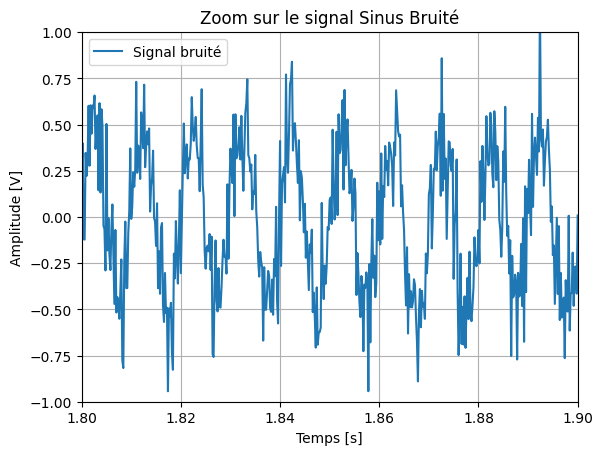

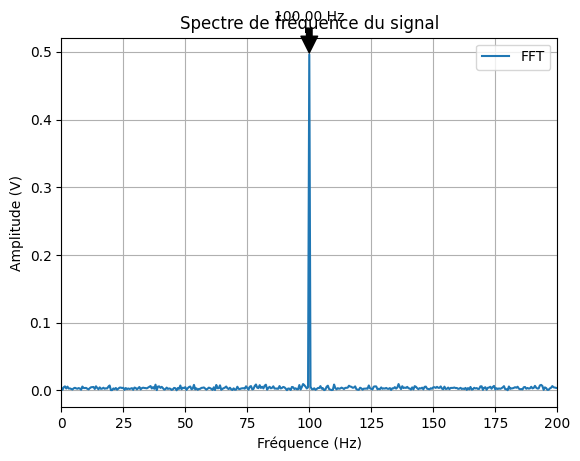

In [126]:
sign_bruité = Graphiques()  #création de l'objet pour les graphiques du signal bruité
sign_bruité.plot_graph(ABSCISSE_GRAPH, 
                       signal_bruité, 
                       'Zoom sur le signal Sinus Bruité',
                       ABSCISSE_GRAPH_TEMPOREL,
                       ORDONNEE_GRAPH_TEMPOREL,
                       "Signal bruité",
                       (1.8, 1.9), 
                       (-1., 1.))   #affichage du graphique du signal bruité
sign_bruité.FFT_Signal(signal_bruité, 
                       FREQ_SAMPLE, 
                       (0, 200), 
                       ABSCISSE_GRAPH_FFT, 
                       ORDONNEE_GRAPH_FFT)    #affichage du graphique FFT du signal bruité

5.4. : Graphiques Bode Nyquist du/des filtre(s) passe-bas

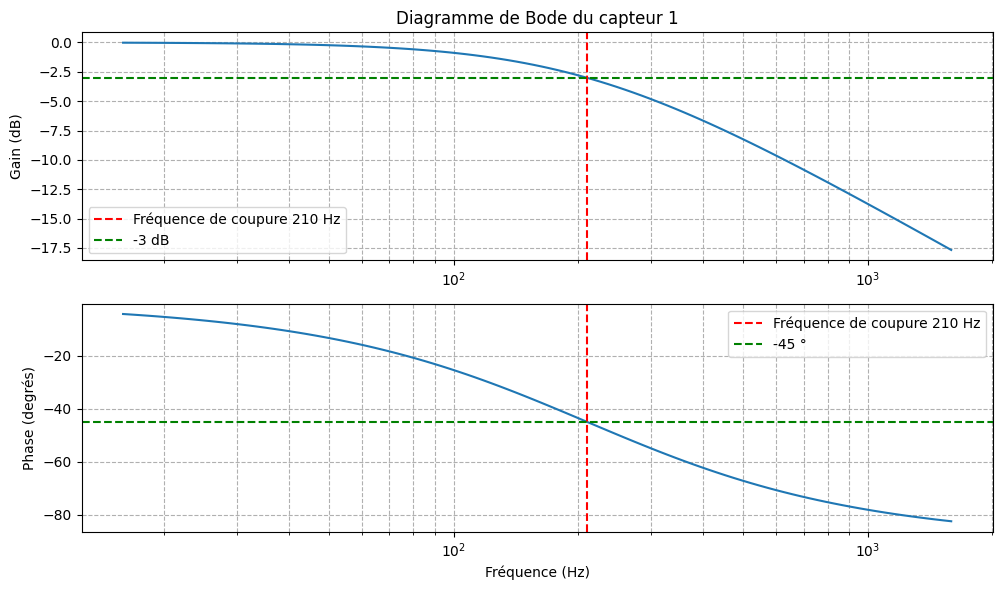

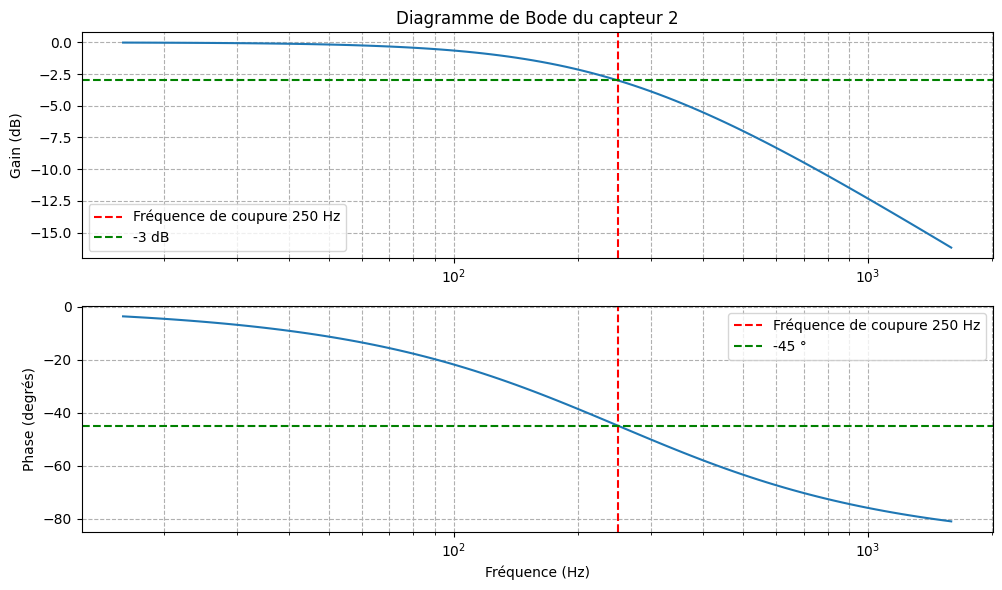

In [127]:
Capt = Graphiques() #création de l'objet pour les graphiques de Bode Nyquist
Capt.Bode_Diagram(filtre_liste, 
                  ORDONNEE_GRAPH_BODE_GAIN, 
                  ABSCISSE_GRAPH_BODE_PHASE, 
                  ORDONNEE_GRAPH_BODE_PHASE) #affichage du diagramme de Bode Nyquist

5.5. : Mise en graphique des signaux de sortie du/des passe-bas

In [128]:
print("taille sortie_filtre:", sortie_filtre[1,:].shape)
for i in filtre_liste:
    print("i", i)

taille sortie_filtre: (2,)
i [1, 210, 1, 'passe-bas', 1.0, 0.04]
i [2, 250, 1, 'passe-bas', 1.0, 0.04]


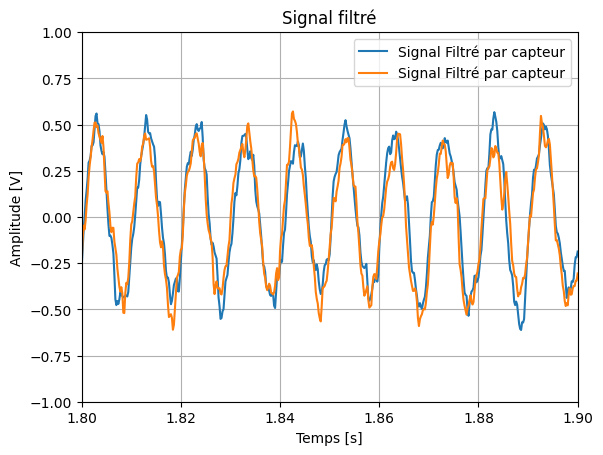

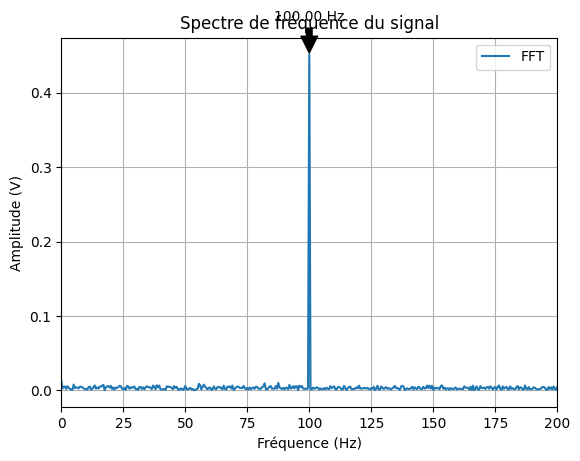

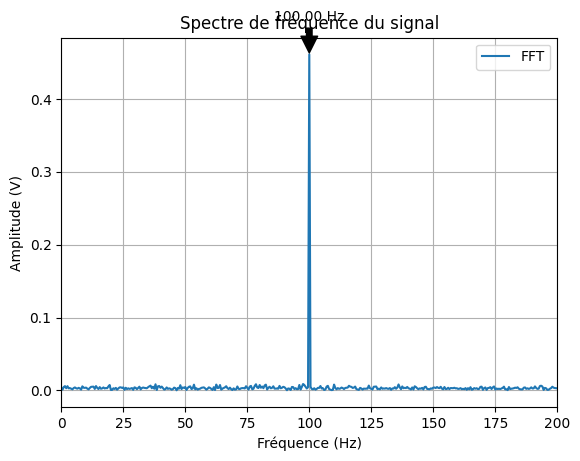

In [129]:
out_capt = Graphiques() #création de l'objet pour les graphiques du signal filtré par le capteur
out_capt.plot_graph(ABSCISSE_GRAPH, 
                    sortie_filtre, 
                    'Signal filtré', 
                    ABSCISSE_GRAPH_TEMPOREL, 
                    ORDONNEE_GRAPH_TEMPOREL, 
                    'Signal Filtré par capteur', 
                    (1.8, 1.9), 
                    (-1., 1.))   #affichage du graphique du signal filtré par le capteur
for i in filtre_liste:
    out_capt.FFT_Signal(sortie_filtre[:,i[0]-1], 
                        FREQ_SAMPLE, 
                        (0,200), 
                        ABSCISSE_GRAPH_FFT, 
                        ORDONNEE_GRAPH_FFT)  #affichage du graphique FFT du signal filtré par le capteur

5.6. : Mise en graphique de la sortie du filtre de Kalman

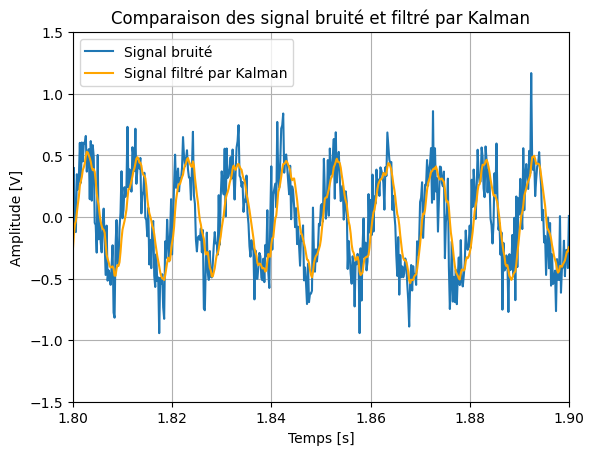

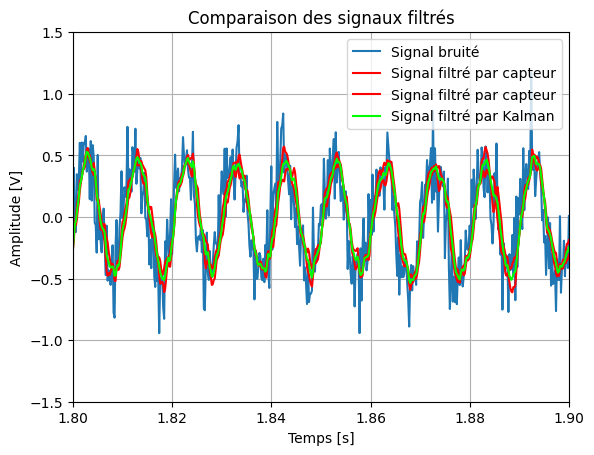

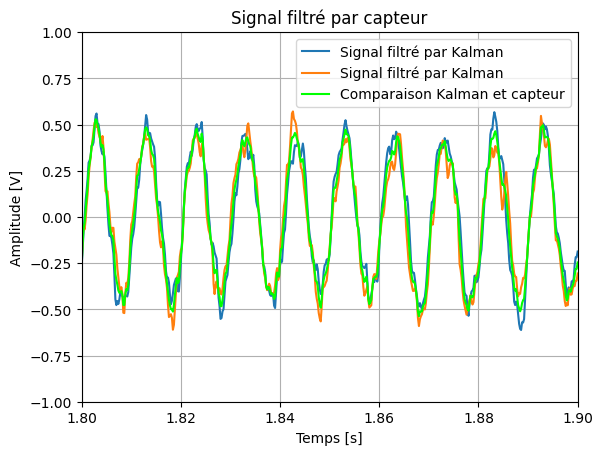

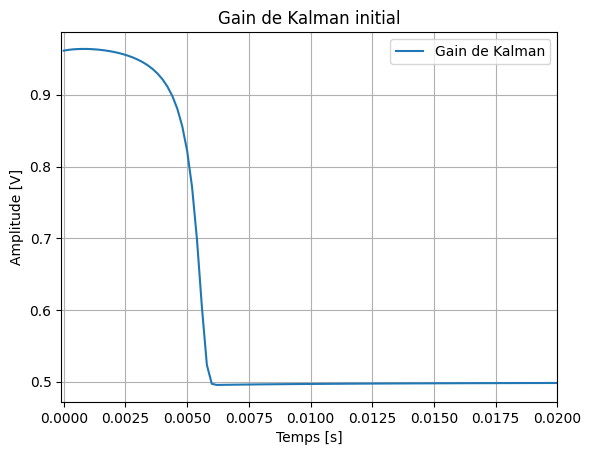

In [130]:
out_kalman = Graphiques()   #création de l'objet pour les graphiques du signal filtré par le filtre de Kalman
out_kalman.plot_graph(ABSCISSE_GRAPH,  
                      signal_bruité, 
                      'Comparaison des signal bruité et filtré par Kalman', 
                      ABSCISSE_GRAPH_TEMPOREL, 
                      ORDONNEE_GRAPH_TEMPOREL, 
                      'Signal bruité',
                      (1.8,1.9), 
                      (-1.5, 1.5), 
                      filtered, 
                      'Signal filtré par Kalman', 
                      'orange',)    #affichage du graphique du signal filtré par le filtre de Kalman
out_kalman.plot_graph(ABSCISSE_GRAPH, 
                      signal_bruité, 
                      'Comparaison des signaux filtrés', 
                      ABSCISSE_GRAPH_TEMPOREL, 
                      ORDONNEE_GRAPH_TEMPOREL, 
                      'Signal bruité',
                      (1.8,1.9), 
                      (-1.5, 1.5),
                      sortie_filtre,
                      'Signal filtré par capteur', 
                      'red', 
                      filtered, 
                      'Signal filtré par Kalman', 
                      'lime')    #affichage du graphique du signal filtré par le filtre de Kalman comparé au signal filtré par le capteur
out_kalman.plot_graph(ABSCISSE_GRAPH,
                      sortie_filtre,
                      'Signal filtré par capteur',
                      ABSCISSE_GRAPH_TEMPOREL, 
                      ORDONNEE_GRAPH_TEMPOREL, 
                      'Signal filtré par Kalman',
                      (1.8,1.9), 
                      (-1., 1.), 
                      filtered, 
                      'Comparaison Kalman et capteur', 
                      'lime')    #affichage du graphique du signal filtré par le filtre de Kalman comparé au signal filtré par le capteur
out_kalman.plot_graph(ABSCISSE_GRAPH, 
                      kalman_gains, 
                      'Gain de Kalman initial', 
                      ABSCISSE_GRAPH_TEMPOREL,
                      ORDONNEE_GRAPH_TEMPOREL, 
                      'Gain de Kalman',
                      (-0.0001,0.02),
                      )  #affichage du graphique du gain de Kalman initial

In [131]:
Calc_Stable_Gain_KF(kalman_gains, 
                    DT, 
                    FILTRE_FC_1)  #calcul du nombre d'échantillons avant que le gain de Kalman soit stable

Constante de temps du filtre passe bas: 0.0007578806813899778 s
Le gain de Kalman devient stable après 2638.673935232525 constantes de temps.


5.8. : Mise en graphique du ripple pré/post Kalman

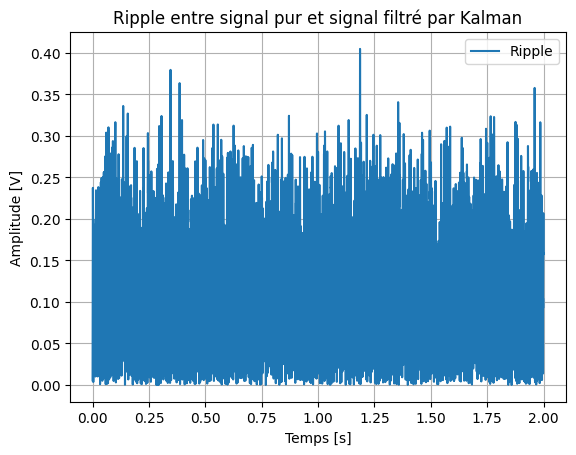

Moyenne du ripple: 0.13217885370793483 V


In [132]:
ripple_graph = Graphiques()  #création de l'objet pour les graphiques du ripple
ripple_graph.plot_graph(ABSCISSE_GRAPH, 
                        ripple, 
                        'Ripple entre signal pur et signal filtré par Kalman', 
                        ABSCISSE_GRAPH_TEMPOREL, 
                        ORDONNEE_GRAPH_TEMPOREL, 
                        'Ripple')  #affichage du graphique du ripple
print("Moyenne du ripple:", np.mean(ripple), "V")   #affichage de la moyenne du ripple

5.9. : Mise en graphique de la moyenne glissante et du filtre de Kalman

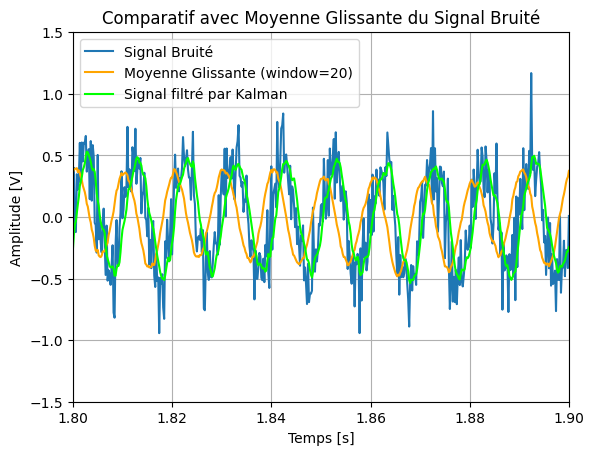

In [133]:
comp_moyenne_glissante = Graphiques()   #création de l'objet pour les graphiques de la moyenne glissante
comp_moyenne_glissante.plot_graph(ABSCISSE_GRAPH[:len(signal_moving_average)], 
                                  signal_bruité[:len(signal_moving_average)], 
                                  'Comparatif avec Moyenne Glissante du Signal Bruité',
                                   ABSCISSE_GRAPH_TEMPOREL, 
                                   ORDONNEE_GRAPH_TEMPOREL, 
                                   'Signal Bruité', 
                                  (1.8, 1.9), 
                                  (-1.5, 1.5), 
                                   signal_moving_average, 
                                   'Moyenne Glissante (window=' + str(TAILLE_FENETRE_MOYENNE_GLISSANTE) + ')', 
                                   'orange', 
                                   filtered[:len(signal_moving_average)], 
                                   'Signal filtré par Kalman', 
                                   'lime')    #affichage du graphique de la moyenne glissante comparée au signal filtré par le filtre de Kalman

Calcul déphasage des signaux (bruité, Kalman et moyenne glissante)

In [134]:
Calc_retard(signal_entree, 
            filtered, 
            SIGNAL_IN_FREQUENCE, 
            DT, 
            "Kalman") #Calcul du retard entre le signal d'entrée non bruité et la sortie du filtre de Kalman
Calc_retard(signal_entree, 
            signal_moving_average, 
            SIGNAL_IN_FREQUENCE, 
            DT, 
            "Moyenne glissante") #Clcul du retard entre le signal d'entrée non bruité et la moyenne glissante

Le retard temporel du signal pur avec Kalman est de -0.0006000000000000001 s.
Le retard degré du signal pur avec Kalman est de -21.599999999999994 °.
Le retard temporel du signal pur avec Moyenne glissante est de 0.0018000000000000002 s.
Le retard degré du signal pur avec Moyenne glissante est de 64.80000000000001 °.


Boucle de 50 pour tester la répétitivité

In [135]:
# ## TEST DE RÉPÉTITIVITÉ SUR 50 FOIS POUR CONTRÔLER LA FIABILITÉ DU CODE ###
# for i in range(50,100):
#     print(f"Step i = {i}")
#     x_file = str(i)
#     text = "filtered_signal_" + x_file + ".csv"
    
#     #sinus
#     Generation_Signal_Entrée = Signal_Original("sinus", 
#                                                SIGNAL_IN_AMPLITUDE, 
#                                                SIGNAL_IN_FREQUENCE, 
#                                                TIMEINOPERATION, 
#                                                FREQ_SAMPLE, 
#                                                ABSCISSE_GRAPH)
#     signal_entree = Generation_Signal_Entrée.GenerationSignal()
#     #bruit
#     gaussian_noise = np.random.normal(W_NOISE_MEAN, 
#                                       W_NOISE_STD, 
#                                       FREQ_SAMPLE * TIMEINOPERATION)
#     #signal bruité
#     signal_bruité = signal_entree + gaussian_noise
#     #passebas
#     somme_filtre=0
#     for i in range(len(filtre_liste)):
#         filtre_id = filtre_liste[i][0]
#         Filtre_fc = filtre_liste[i][1]
#         Filtre_Ordre = filtre_liste[i][2]
#         Filtre_type = filtre_liste[i][3]
#         Filtre_gain = filtre_liste[i][4]
#         Filtre = SignalFilter(signal_bruité, 
#                               Filtre_type, 
#                               Filtre_gain, 
#                               Filtre_fc, 
#                               Filtre_Ordre, 
#                               FREQ_SAMPLE, 
#                               W_NOISE_STD, 
#                               signal_entree)
#         Filtre.Sortie_Filtre_passe_bas()
#         somme_filtre += Filtre.Sortie_Filtre_passe_bas()
#     #Kalman
#     filtered, kalman_gains = Filtre.Filtre_kalman(somme_filtre, 
#                                                   KALMAN_R, 
#                                                   KALMAN_P0, 
#                                                   KALMAN_X0)
#     #Moyenne glissante
#     signal_moving_average = Moyenne_Glissante(signal_bruité, 
#                                               TAILLE_FENETRE_MOYENNE_GLISSANTE)  
#     #calcul RMS des signaux
#     RMS_Entree = np.sqrt(np.mean(signal_entree**2))
#     RMS_Bruité = np.sqrt(np.mean(signal_bruité**2))
#     RMS_FiltréRC = np.sqrt(np.mean(somme_filtre**2))
#     RMS_Kalman = np.sqrt(np.mean(filtered**2))
#     RMS_Moyenne_Glissante = np.sqrt(np.mean(signal_moving_average**2))
#     print(f"RMS Signal d'entrée : {RMS_Entree} V")
#     print(f"RMS Signal bruité : {RMS_Bruité} V")
#     print(f"RMS Signal filtré RC : {RMS_FiltréRC} V")
#     print(f"RMS Signal filtré Kalman : {RMS_Kalman} V")
#     print(f"RMS Signal Moyenne Glissante : {RMS_Moyenne_Glissante} V")

#     #calcul SNR en utilisant l'amplitude RMS des signaux
#     SNR_Bruité = 20 * log10(RMS_Entree / RMS_Bruité)
#     SNR_FiltréRC = 20 * log10(RMS_Entree / RMS_FiltréRC)
#     SNR_Kalman = 20 * log10(RMS_Entree / RMS_Kalman)
#     SNR_Moyenne_Glissante = 20 * log10(RMS_Entree / RMS_Moyenne_Glissante)
#     print(f"SNR Signal bruité : {SNR_Bruité} dB")
#     print(f"SNR Signal filtré RC : {SNR_FiltréRC} dB")
#     print(f"SNR Signal filtré Kalman : {SNR_Kalman} dB")
#     print(f"SNR Signal Moyenne Glissante : {SNR_Moyenne_Glissante} dB")
#     #export CSV
#     with open(text, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Time (s)', 'Signal d\entrée', 'Signal Bruité', 'Signal filtré par le capteur', 'Signal filtré par Kalman'])
#         for t, s_in, s_bruite, s_filtre_capteur, s_filtre_kalman in zip(ABSCISSE_GRAPH, signal_entree, signal_bruité, somme_filtre, filtered):
#             writer.writerow([t, s_in, s_bruite, s_filtre_capteur, s_filtre_kalman])

#     print(f"Exportation des données terminée dans {text}.")

In [136]:
# # """Portion de code pour l'animation du filtre de Kalman"""
# x = np.linspace(1.8, 2.0, 1000)  #abscisse du graphique temporel en secondes
# y_noise = 0.5 * np.sin(200*np.pi*x) + np.random.normal(W_NOISE_MEAN, W_NOISE_STD, 1000) #génération du signal bruité
# #suppression d'une partie du signal d'entrée pour tester le filtre de Kalman
# for i in range(len(y_noise)):
#     if (x[i] >= 1.85) and (x[i] < 1.86):
#         y_noise[i] = 0.

# #passage du signal bruité dans le filtre passe-bas
# y_lp=0  #initialisation du signal après passage dans le/les filtre(s) passe-bas
# for i in filtre_liste:
#     filtre = SignalFilter(y_noise, 
#                           i[3], 
#                           i[4], 
#                           i[1], 
#                           i[2], 
#                           FREQ_SAMPLE, 
#                           W_NOISE_STD, 
#                           signal_entree)
#     y_lp += filtre.Sortie_Filtre_passe_bas()

# filtered, kalman_gains = filtre.Filtre_kalman(y_lp, 0.1, 10., KALMAN_X0)    #application du filtre de Kalman

# fig, ax = plt.subplots()    #création de la figure et des axes
# line_noise, = ax.plot([], [], label="Bruité", color="red")  #ligne pour le signal bruité
# line_lp, = ax.plot([], [], label="Capteur", color="blue")   #ligne pour le signal après passage dans le filtre passe-bas
# line_kalman, = ax.plot([], [], label="Kalman", color="green")   #ligne pour le signal après passage dans le filtre de Kalman
# ax.legend() #ajout de la légende
# ax.set_xlim(1.7, 1.8)   #limites de l'axe x
# ax.set_ylim(-1.5, 1.5)  #limites de l'axe y
# ax.grid(True)   #ajout de la grille

# window = 0.1    #taille de la fenêtre temporelle affichée en secondes

# def init(): #initialisation des lignes
#     line_noise.set_data([], []) #ligne pour le signal bruité
#     line_lp.set_data([], [])    #ligne pour le signal après passage dans le filtre passe-bas
#     line_kalman.set_data([], [])    #ligne pour le signal après passage dans le filtre de Kalman
#     return line_noise, line_lp, line_kalman

# def update(i):  #mise à jour des lignes pour chaque frame
#     t_current = x[i]    #temporel
#     t_start = t_current - window    #début de la fenêtre temporelle
#     t_end = t_current   #fin de la fenêtre temporelle
#     mask = (x >= t_start) & (x <= t_end)    #masque pour sélectionner les données dans la fenêtre temporelle
#     line_noise.set_data(x[mask], y_noise[mask])  #mise à jour des données du signal bruité
#     line_lp.set_data(x[mask], y_lp[mask])   #mise à jour des données du signal après passage dans le filtre passe-bas
#     line_kalman.set_data(x[mask], filtered[mask])   #mise à jour des données du signal après passage dans le filtre de Kalman
#     ax.set_xlim(t_start, t_end)  #mise à jour des limites de l'axe x
#     return line_noise, line_lp, line_kalman

# ani = FuncAnimation(fig, update, frames=range(len(x)), init_func=init,
#                     interval=50, blit=False)    #création de l'animation

# writer = PillowWriter(fps=50)   #enregistrement de l'animation au format GIF
# ani.save("animation_kalman.gif", writer=writer) #sauvegarde de l'animation
# plt.close(fig)  #fermeture de la figure pour libérer la mémoire

Test Monte Carlo sur 100 itérations (controle du signal bruité, du signal filtré par capteur et du signal filtré par Kalman)

i: [1, 210, 1, 'passe-bas', 1.0, 0.04]

RMSE moyen par réalisation (Monte Carlo) + MCSE :
  - Signal bruité : 0.1999 +/- 0.0047 (RMSE +/- MCSE)
  - Filtre capteur : 0.1686 +/- 0.0039 (RMSE +/- MCSE)
  - Filtre de Kalman : 0.1515 +/- 0.0035 (RMSE +/- MCSE)


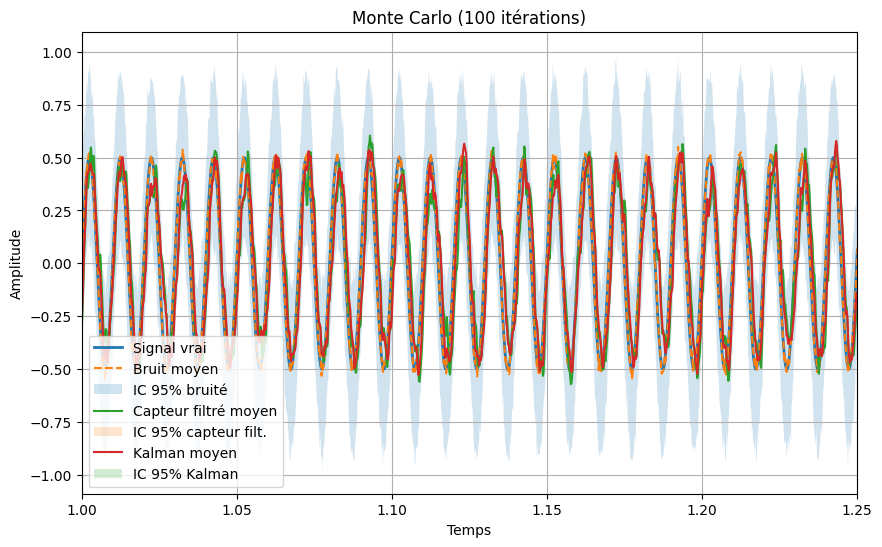

i: [2, 250, 1, 'passe-bas', 1.0, 0.04]

RMSE moyen par réalisation (Monte Carlo) + MCSE :
  - Signal bruité : 0.2003 +/- 0.0047 (RMSE +/- MCSE)
  - Filtre capteur : 0.1513 +/- 0.0035 (RMSE +/- MCSE)
  - Filtre de Kalman : 0.1515 +/- 0.0035 (RMSE +/- MCSE)


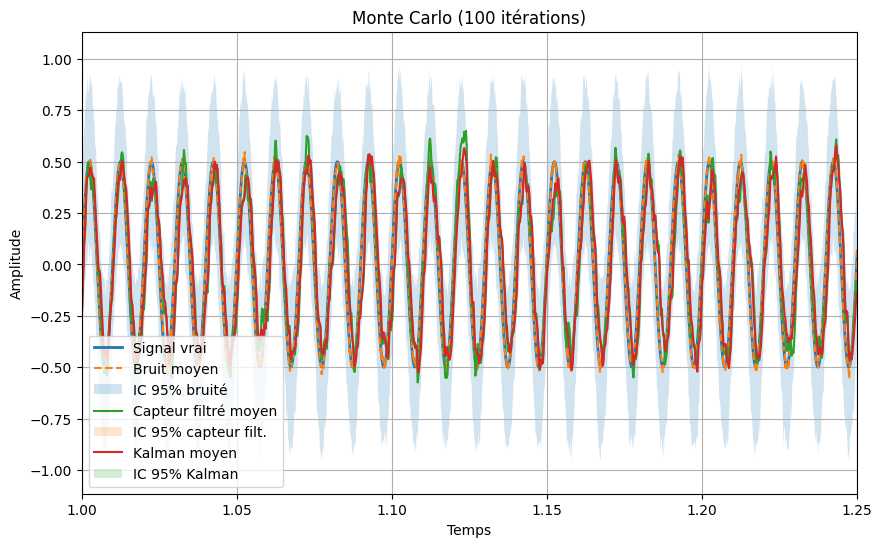

In [ ]:
# for i in filtre_liste:
#     Monte_Carlo_Results = Monte_Carlo(signal_entree, 
#                                     ABSCISSE_GRAPH, 
#                                     W_NOISE_MEAN, 
#                                     W_NOISE_STD, 
#                                     sortie_filtre[:,i[0]-1], 
#                                     filtered, 
#                                     100)
#     Monte_Carlo_Results.Monte_Carlo_Method()